Go to <a href=#bookmark>my bookmark</a>

In [89]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

In [45]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

In [46]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

# add title

In [48]:
# add title

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Don           1
Sir           1
Capt          1
Countess      1
Ms            1
Jonkheer      1
Mme           1
Lady          1
Name: Title, dtype: int64

## try one hote encoding without delete rare title

In [49]:
# try one hote encoding without delete rare title
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 11) (418, 10)
(1309, 11)
(891, 28) (418, 27)


In [50]:
test_df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Title_Capt,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,34.5,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,0,...,0,0,0,0,0,1,0,0,0,0
1,47.0,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,0,...,0,0,0,0,0,0,1,0,0,0
2,62.0,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,0,...,0,0,0,0,0,1,0,0,0,0
3,27.0,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,0,...,0,0,0,0,0,1,0,0,0,0
4,22.0,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,0,...,0,0,0,0,0,0,1,0,0,0


## del rare title and map value

# drop Name, PassengerId

In [51]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name', 'PassengerId'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,S,7.2500,0,3,male,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38.0,C,71.2833,0,1,female,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26.0,S,7.9250,0,3,female,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35.0,S,53.1000,0,1,female,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35.0,S,8.0500,0,3,male,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


# map value to Sex 

In [52]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38.0,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26.0,S,7.9250,0,3,1,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35.0,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35.0,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


# fill na value

In [53]:
train_df.isna().any()

Age                True
Embarked           True
Fare              False
Parch             False
Pclass            False
Sex               False
SibSp             False
Survived          False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

In [54]:
test_df.isna().any()

Age                True
Embarked          False
Fare               True
Parch             False
Pclass            False
Sex               False
SibSp             False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

## fill na of Age

In [55]:
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26,S,7.9250,0,3,1,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [56]:
train_df.isna().any()

Age               False
Embarked           True
Fare              False
Parch             False
Pclass            False
Sex               False
SibSp             False
Survived          False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

### 2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

## add age band

In [57]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,AgeBand
0,22,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,1,0,0,0,0,"(16.0, 32.0]"
1,38,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,1,0,0,0,"(32.0, 48.0]"
2,26,S,7.9250,0,3,1,0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,"(16.0, 32.0]"
3,35,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,1,0,0,0,"(32.0, 48.0]"
4,35,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,"(32.0, 48.0]"


## Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [58]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,1,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,S,7.9250,0,3,1,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Create new feature

In [59]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    

train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,FamilySize,IsAlone,Age*Class
0,1,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,1,0,0,0,0,2,0,3
1,2,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,1,0,0,0,2,0,2
2,1,S,7.9250,0,3,1,0,1.0,0,0,...,0,0,0,0,0,0,0,1,1,3
3,2,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,1,0,0,0,2,0,2
4,2,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,1,0,0,0,0,1,1,6


# select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

In [60]:
# keep Parch, SibSp only. this was best amoung familly related features

train_df = train_df.drop(['FamilySize', 'IsAlone'], axis=1)
test_df = test_df.drop(['FamilySize', 'IsAlone'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Age*Class
0,1,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,1,0,0,0,0,3
1,2,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,1,0,0,0,2
2,1,S,7.9250,0,3,1,0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,3
3,2,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,1,0,0,0,2
4,2,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,6


# fill missing Embarked 

In [61]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)


# Converting Embarked categorical feature to numeric

# try one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

In [62]:
# try one hote encoding for Embarked
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Embarked"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

train_df.head()

(891, 27) (418, 26)
(1309, 27)
(891, 29) (418, 28)


,Age,Age*Class,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,7.2500,0,3,0,1,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,7.9250,0,3,1,0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,8.0500,0,3,0,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1


# fill na of test data Fare

In [63]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,Age,Age*Class,Fare,Parch,Pclass,Sex,SibSp,Title_Capt,Title_Col,Title_Countess,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,2,6,7.8292,0,3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,6,7.0000,0,3,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,3,6,9.6875,0,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1,3,8.6625,0,3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,3,12.2875,1,3,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


# make Fareband feature

In [64]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]
    
train_df.head(10)

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,Age,Age*Class,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,0,0,3,0,1,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,3,0,1,1,1,1.0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,1,0,3,1,0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,3,0,1,1,1,1.0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,1,0,3,0,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,1,3,1,0,3,0,0,0.0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,3,3,3,0,1,0,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,0,0,2,1,3,0,3,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,1,3,1,2,3,1,0,1.0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,0,0,2,0,2,1,1,1.0,0,0,...,0,0,0,1,0,0,0,1,0,0


## try more fare band number

- no difference

## keep Fare feature and add FareBand numerical feature¶

- not good result

----

# model and estimate

In [65]:
X_train_df.head()

,Age,Age*Class,Fare,Parch,Pclass,Sex,SibSp,Title_Capt,Title_Col,Title_Countess,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,1,3,0,0,3,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,2,3,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,1,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,3,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,6,1,0,3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


## try several models

In [66]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

In [67]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, X_train_df, y_train_df)
scores.mean()

0.8125701459034792

In [68]:
scores

array([0.8047138 , 0.8013468 , 0.83164983])

In [69]:
svc = SVC(C=10.0, kernel="rbf")
scores = cross_val_score(svc, X_train_df, y_train_df)
scores.mean()

0.8305274971941637

In [70]:
gaussianNb = GaussianNB()
scores = cross_val_score(gaussianNb, X_train_df, y_train_df)
scores.mean()

0.681257014590348

In [71]:
perceptron = Perceptron()
scores = cross_val_score(perceptron, X_train_df, y_train_df)
scores.mean()

/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/yuki/.local/lib/python3.6/site-packages/skle

0.6969696969696969

In [72]:
linear_svc = LinearSVC()
scores = cross_val_score(linear_svc, X_train_df, y_train_df)
scores.mean()

0.8148148148148149

In [73]:
sgd = SGDClassifier()
scores = cross_val_score(sgd, X_train_df, y_train_df)
scores.mean()

/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/yuki/.local/lib/pyth

0.7205387205387206

In [74]:
decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, X_train_df, y_train_df)
scores.mean()

0.7934904601571269

In [75]:
random_forest = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(random_forest, X_train_df, y_train_df)
scores.mean()

0.8159371492704826

----

# make train, test data set from train.csv

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)

train/test data shape (596, 28) (295, 28)


best scroe:  0.8171140939597316
best estimator: SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
test:  0.8440677966101695


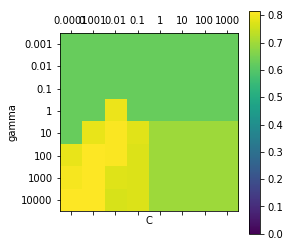

In [77]:
# make wide the ranges

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(8, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()

print("best scroe: ", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)
print("test: ", grid_search.score(X_test, y_test))

----

# apply preprocessing

In [78]:
X_train.head()

,Age,Age*Class,Fare,Parch,Pclass,Sex,SibSp,Title_Capt,Title_Col,Title_Countess,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
6,3,3,3,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
718,1,3,2,0,3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
685,1,2,3,2,2,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
73,1,3,2,0,3,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
882,1,3,1,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Min Max Scaler

In [79]:
#minmaxScaler = MinMaxScaler()
#minmaxScaler.fit(X_train)

#X_minmaxScaled = minmaxScaler.transform(X)
#X_minmaxScaled[0]

In [80]:
# grid search SVC
# use cross_val_score

#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
#              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

#param_grid = [{'kernel': ['rbf'],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100],
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
#              {'kernel': ['linear'],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

#grid_search = GridSearchCV(SVC(), param_grid, cv=5)
#grid_search.fit(X_minmaxScaled, y, cv=5)

#scores = cross_val_score(grid_search, X_minmaxScaled, y, cv=5)
#print("train", scores.mean())

In [81]:
# grid search for pipeline
param_grid = {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
pipe = make_pipeline(MinMaxScaler(), SVC())

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("grid search best score", grid.best_score_)
print("test", grid.score(X_test, y_test))
print("best_params_", grid.best_params_)

grid search best score 0.8322147651006712
test 0.823728813559322
best_params_ {'svc__C': 1, 'svc__gamma': 1}


## StandardScaler

In [82]:
# grid search for pipeline
param_grid = {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

pipe = make_pipeline(StandardScaler(), SVC())

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("grid search best score", grid.best_score_)
print("test", grid.score(X_test, y_test))
print("best_params_", grid.best_params_)

grid search best score 0.8389261744966443
test 0.8135593220338984
best_params_ {'svc__C': 1, 'svc__gamma': 0.1}


## RobustScaler

In [83]:
# grid search for pipeline
param_grid = {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

pipe = make_pipeline(RobustScaler(), SVC())

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("grid search best score", grid.best_score_)
print("test", grid.score(X_test, y_test))
print("best_params_", grid.best_params_)

grid search best score 0.8171140939597316
test 0.8169491525423729
best_params_ {'svc__C': 10, 'svc__gamma': 0.1}


----
# feature extraction

## use PCA

In [94]:
"""
pca = PCA(n_components=2)
pca.fit(X_scaled)
# 最初の2つの主成分に対してデータポイントを変換
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
"""

# grid search for pipeline
param_grid = {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             'pca__n_components':[2,4,6,8,10, 12, 14, 16, 18, 20]}

pipe = make_pipeline(RobustScaler(), PCA(), SVC())

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("grid search best score", grid.best_score_)
print("test", grid.score(X_test, y_test))
print("best_params_", grid.best_params_)

grid search best score 0.8204697986577181
test 0.8440677966101695
best_params_ {'pca__n_components': 12, 'svc__C': 100, 'svc__gamma': 0.01}


## use NMF

**todo**

In [ ]:

# grid search for pipeline
param_grid = {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             'pca__n_components':[2,4,6,8,10, 12, 14, 16, 18, 20]}

pipe = make_pipeline(RobustScaler(), NMF(), SVC())

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("grid search best score", grid.best_score_)
print("test", grid.score(X_test, y_test))
print("best_params_", grid.best_params_)

----

# random forest result for compare

In [84]:
X_test.shape, y_test.shape

((295, 28), (295,))

In [85]:
param_grid = {'randomforestclassifier__n_estimators': [5, 10, 20, 30, 50, 100, 300],
              'randomforestclassifier__max_features': [1, 'auto', None],
             'randomforestclassifier__max_depth':[1, 5, 10, None],
             'randomforestclassifier__min_samples_leaf': [1,2,4]}

pipe = make_pipeline(MinMaxScaler(), RandomForestClassifier(n_estimators=100))

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=3)
grid_search.fit(X_train, y_train)

print("best scroe: ", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)
print("best param:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

#scores = cross_val_score(grid_search, X_train_df, y_train_df, cv=5)
#print("cross eval for all", scores.mean())

best scroe:  0.8288590604026845
best estimator: Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
best param: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 1, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 300}
test:  0.8169491525423729


## GradientBoostingClassifier

best scroe:  0.8322147651006712
best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
test:  0.8305084745762712


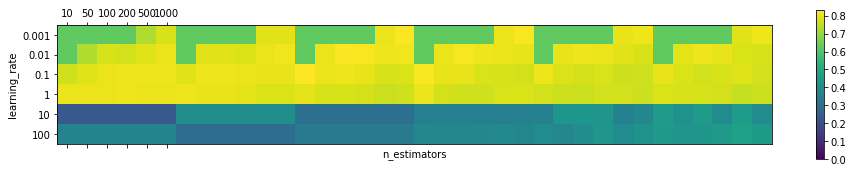

In [86]:
param_grid = {'n_estimators': [10, 50, 100, 200, 500, 1000],
              'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
             'max_depth':[1,2,3,4,5,6]}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=3)
grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(6, -1),
            vmin=0, cmap="viridis")
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.xticks(range(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.yticks(range(len(param_grid['learning_rate'])), param_grid['learning_rate'])
plt.colorbar()

print("best scroe: ", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)
print("test: ", grid_search.score(X_test, y_test))

## todo: how to make a matshow correctly for 3 variables?